In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta
from pytz import timezone

import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [2]:
# read in data 
df=pd.read_csv('IND3_EventData.csv')
df.head()

,EVENT_DAY,TRACKINGEVENTKEY,CNT
0,2021-05-20 00:00:00.000,334,2462
1,2021-05-20 00:00:00.000,333,2916
2,2021-05-20 00:00:00.000,35,1883
3,2021-05-20 00:00:00.000,7,1156
4,2021-05-20 00:00:00.000,14,7677


In [3]:
#rename column
old_name=[df.columns[ind] for ind in range(3)]
new_name=['EVENT_DATE',
          'EVENT_KEY',
          'PGK_COUNT'         
         ]
for old_col, new_col in zip(old_name,new_name):
    df.rename(columns={old_col:new_col},inplace=True)

df.head()

,EVENT_DATE,EVENT_KEY,PGK_COUNT
0,2021-05-20 00:00:00.000,334,2462
1,2021-05-20 00:00:00.000,333,2916
2,2021-05-20 00:00:00.000,35,1883
3,2021-05-20 00:00:00.000,7,1156
4,2021-05-20 00:00:00.000,14,7677


In [4]:
#group-by parameter
date_variable, tracking_variable, actual_value = new_name
tracking_object='Event'

In [5]:
# find min and max datetime in data and change to datetime format
print(min(df[date_variable]),'-',max(df[date_variable]))
df[date_variable]=pd.to_datetime(df[date_variable])

df.head()

2020-06-01 01:00:00.000 - 2021-05-20 00:00:00.000


,EVENT_DATE,EVENT_KEY,PGK_COUNT
0,2021-05-20,334,2462
1,2021-05-20,333,2916
2,2021-05-20,35,1883
3,2021-05-20,7,1156
4,2021-05-20,14,7677


In [6]:
total_day=(max(df[date_variable]) - min(df[date_variable])).days
print(total_day)

352


In [7]:
# import prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [8]:
# empty dataframe to append forecast results
Final=pd.DataFrame()

In [9]:
# find unique trackingID
tracking_list=list(df[tracking_variable].unique())
print(tracking_list)

[334, 333, 35, 7, 14, 335, 33, 339, 337, 336, 325, 75, 76]


In [10]:
# length of training period (days) - 70% of total days
training_period=round(0.7*total_day,0) 

# training interval increment (days)
interval=7

# window between checkpoint (hours)
window='6H'

#number of forecast (based on windows between checkpoint)
number_of_forecast = 24/int(window[0])

for trk in tracking_list:
    print(tracking_object,trk)

    # sort tracking event by key
    pre_train=df[df[tracking_variable]==trk]

    #drop trackingID column
    pre_train.drop([tracking_variable],axis=1,inplace=True) 

    # the n+1 day - the day after as a start date for forecasting
    min_val=(min(pre_train[date_variable])+timedelta(days=1)).round('D')
    max_val=max(pre_train[date_variable])

    temp=pd.DataFrame()

    # sort datetime by Event_Key
    # 6-hour increment
    temp[date_variable]=pd.Series(pd.date_range(min_val,max_val,freq=window))

    pre_train=pre_train.merge(temp,how='right',left_on=date_variable,right_on=date_variable)
    pre_train[date_variable]=pre_train[date_variable].fillna(0)

    # training period
    len_train=pd.to_datetime(min_val)+timedelta(days=training_period) 
    flag=len_train

#     pre_train.dropna(inplace=True)
    pre_train=pre_train.sort_values([date_variable])

    while (flag+timedelta(days=interval))<=pd.to_datetime(max_val):
        forecast=pd.DataFrame()

        # training set with datetime smaller than flag
        # rename column and convert to datetime format
        train=pre_train[pre_train[date_variable]<flag]
        train.columns = ['ds', 'y']
        train['ds']= pd.to_datetime(train['ds'])

        # define the model
        model = Prophet(interval_width=0.95)
#         daily_seasonality=True
#         yearly_seasonality=False

        # fit the model
        model.fit(train)

        # future dataframe with the beginning of training period as a start date
        # 6-hourly period in 7 days
        future=pd.DataFrame(pd.Series(pd.date_range(start=flag, periods=number_of_forecast*interval,\
                                                    freq=window)),columns=['ds'])

        forecast = model.predict(future)
        forecast[tracking_object]=trk

        #append forecast result
        Final=Final.append(forecast)
        flag=flag+timedelta(days=interval)

Event 334


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Event 333


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Event 35


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event 7


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event 14


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event 335


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event 33


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event 339
Event 337


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event 336


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


Event 325
Event 75
Event 76


In [11]:
#group-by for output file
col_list=['ds',
          'yhat',
          'yhat_lower',
          'yhat_upper'
         ]
forecast_datetime, predicted_value, lower_value, upper_value = col_list

In [12]:
# final y-hat=0 if smaller than 0
Final[predicted_value]=np.where(Final[predicted_value]<0,0,Final[predicted_value])

df_t=df
df_t[date_variable]=pd.to_datetime(df_t[date_variable])

Final_CSV=Final.merge(df_t,how='left',left_on=[forecast_datetime,tracking_object],\
                      right_on=[date_variable,tracking_variable])
Final_CSV[actual_value]=Final_CSV[actual_value].fillna(0)
Final_CSV.to_csv('IND3_Anomaly_Output_7Day.csv')

In [13]:
final_tracking_list=list(Final_CSV[tracking_object].unique())
print(final_tracking_list)

total_final_day=(max(Final_CSV[forecast_datetime]) - min(Final_CSV[forecast_datetime])).days
print(total_final_day)

[334, 333, 35, 7, 14, 335, 33, 337, 336]
104


In [14]:
# cleaning before visualization

# no negative volume: 0 for yhat_lower < 0
Final_CSV[lower_value]=np.where(Final_CSV[lower_value]<0,0,Final_CSV[lower_value])

# round to nearest int
values_need_rounding=[upper_value,lower_value,predicted_value]

for val in values_need_rounding:
    Final_CSV[val]=Final_CSV[val].round(decimals=0)

Final_CSV.head()
# Final_CSV.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Event,EVENT_DATE,EVENT_KEY,PGK_COUNT
0,2021-04-11 00:00:00,47.253108,0.0,9043.0,47.246845,47.253108,-1655.940969,-1655.940969,-1655.940969,-235.507395,...,-1420.433575,-1420.433575,0.0,0.0,0.0,0.0,334,NaT,NaN,0.0
1,2021-04-11 06:00:00,41.979982,0.0,10534.0,41.879136,42.009434,-141.540576,-141.540576,-141.540576,995.674503,...,-1137.215079,-1137.215079,0.0,0.0,0.0,0.0,334,NaT,NaN,0.0
2,2021-04-11 12:00:00,36.706857,0.0,16826.0,36.474387,36.843190,6563.287468,6563.287468,6563.287468,7330.315123,...,-767.027655,-767.027655,0.0,0.0,0.0,6600.0,334,NaT,NaN,0.0
3,2021-04-11 18:00:00,31.433732,0.0,13392.0,31.062425,31.728644,2521.848147,2521.848147,2521.848147,2910.677008,...,-388.828861,-388.828861,0.0,0.0,0.0,2553.0,334,2021-04-11 18:00:00,334.0,14040.0
4,2021-04-12 00:00:00,26.160607,0.0,10004.0,25.568087,26.722786,-302.605909,-302.605909,-302.605909,-235.507395,...,-67.098514,-67.098514,0.0,0.0,0.0,0.0,334,2021-04-12 00:00:00,334.0,880.0


In [15]:
# plot elements
graph_type='line'
y_axis=[lower_value,
        upper_value,
        predicted_value,
        actual_value]
label_list=['Lower-bound',
            'Upper-bound',
            'Predicted Values',
            'Actual Values']
color_list=['blue',
            'red',
            'gold',
            'green']

Event 334


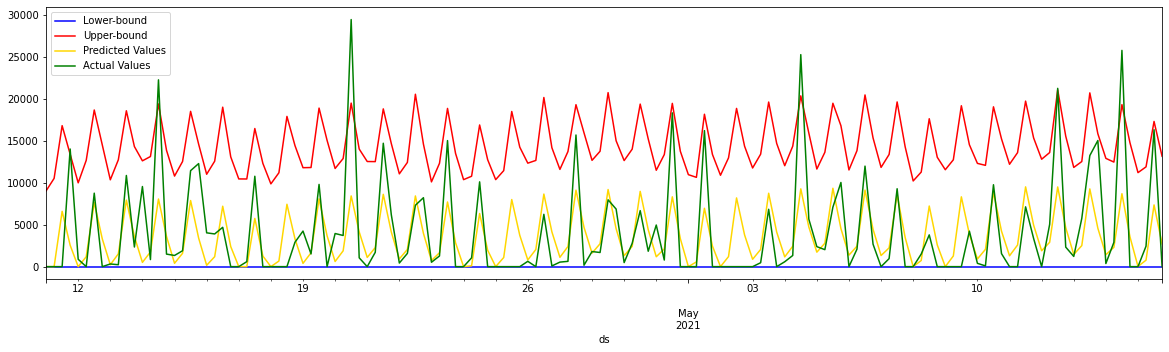

Event 333


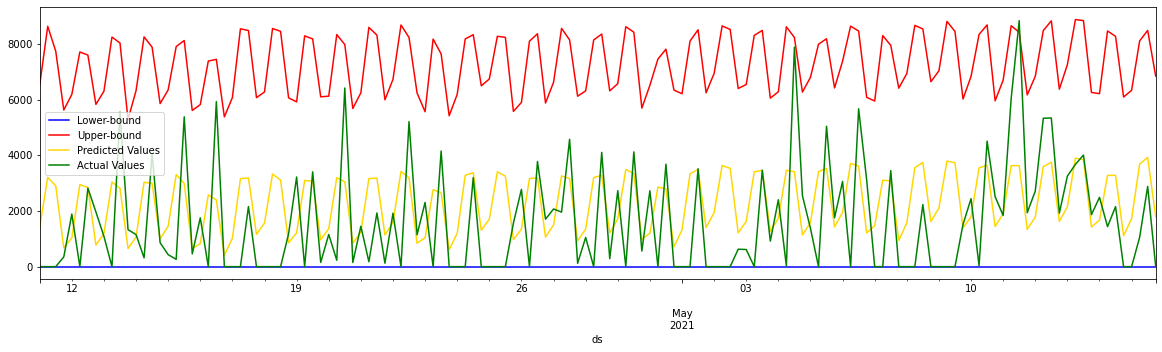

Event 35


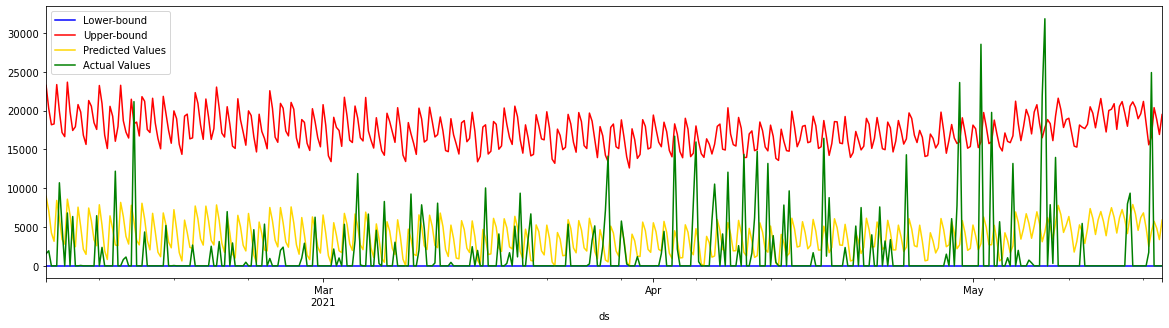

Event 7


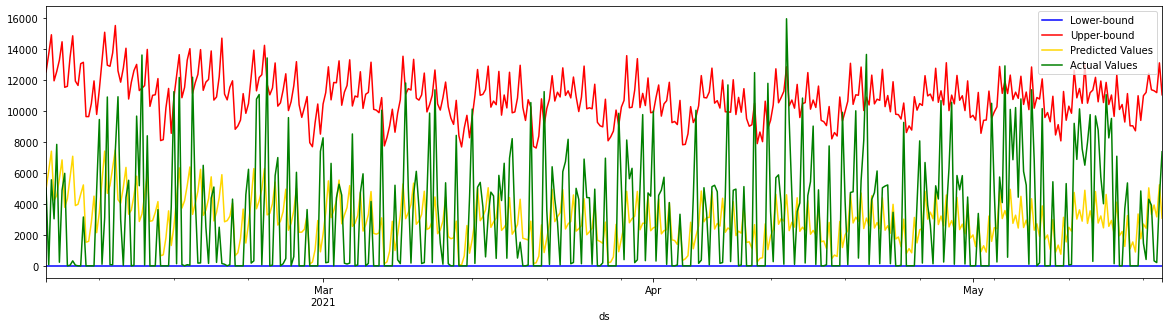

Event 14


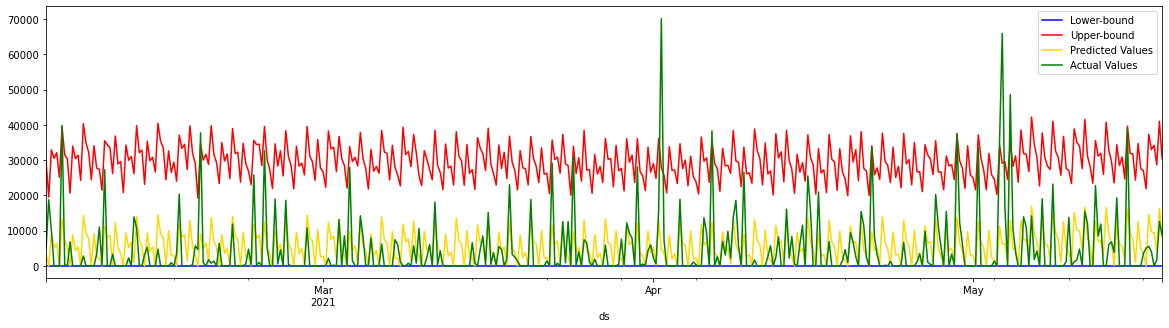

Event 335


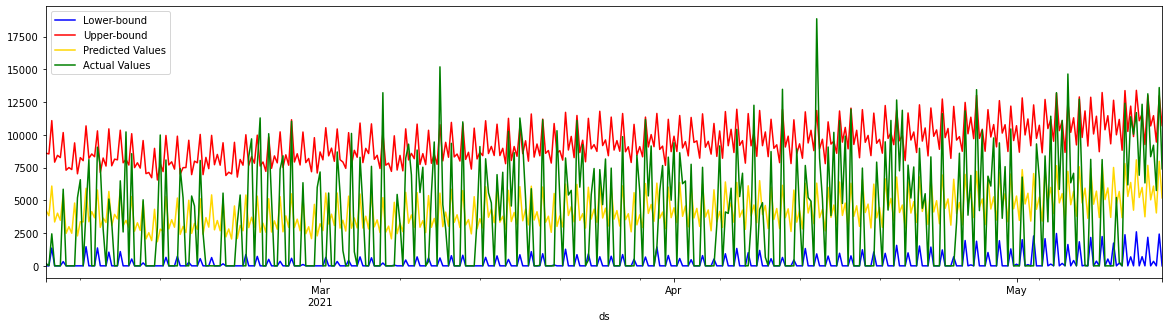

Event 33


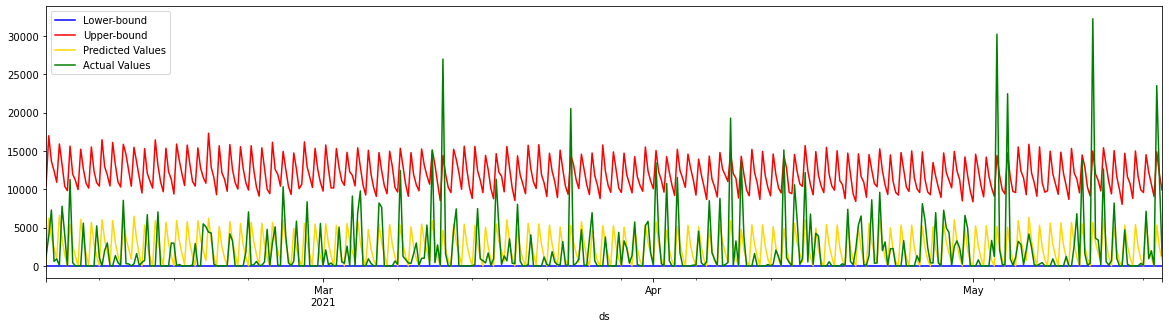

Event 337


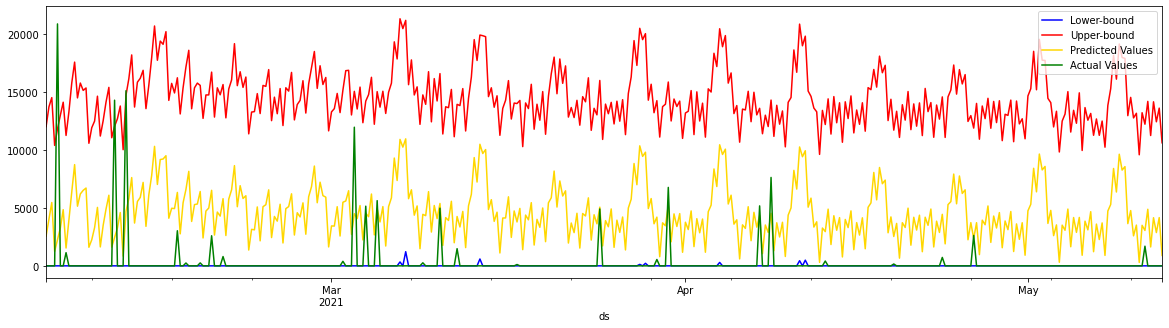

Event 336


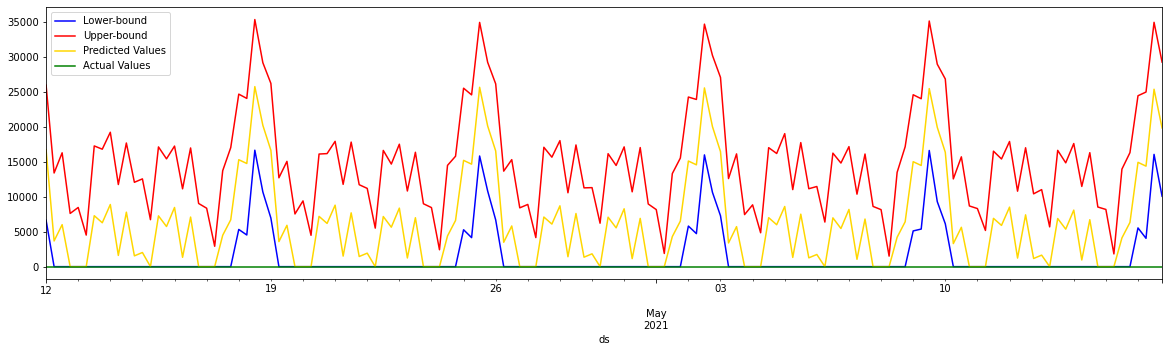

In [16]:
#all time - graph plot with date, confidence interval, predicted and actual values

for final_trk in final_tracking_list:
    print(tracking_object,final_trk) 

    spec_trk=Final_CSV[Final_CSV[tracking_object] == final_trk]

    ax = plt.gca()

    for y_val, labl, colr in zip(y_axis,label_list,color_list):
        spec_trk.plot(kind=graph_type,x=forecast_datetime,y=y_val, color=colr, label=labl, \
                        ax=ax, figsize=(20, 5))

    plt.fill_between(spec_trk.index, spec_trk.yhat_upper, spec_trk.yhat_lower, facecolor='orange',alpha=0.5)
    plt.show()

Event 334


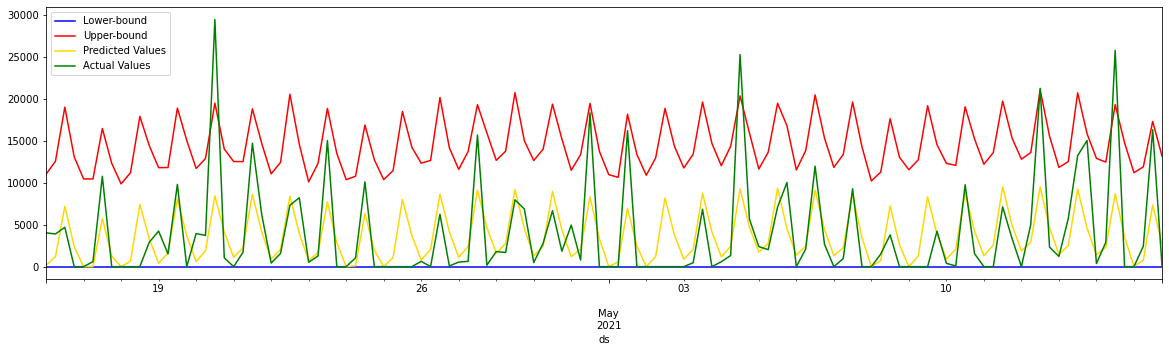

Event 333


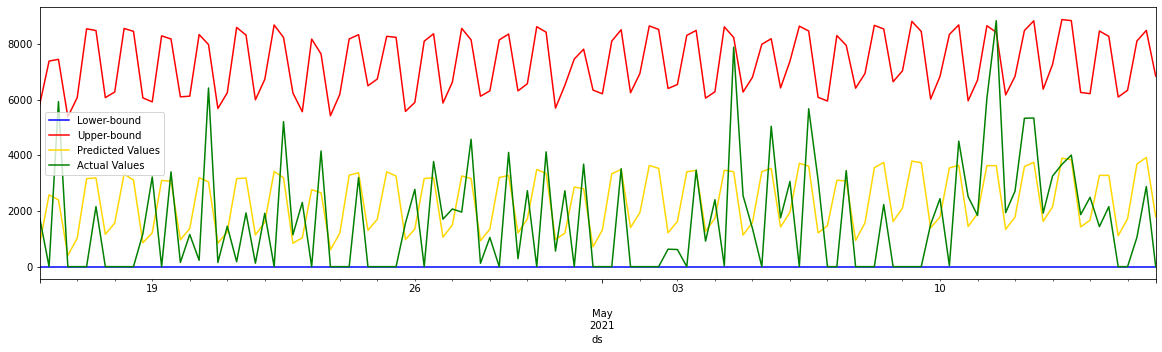

Event 35


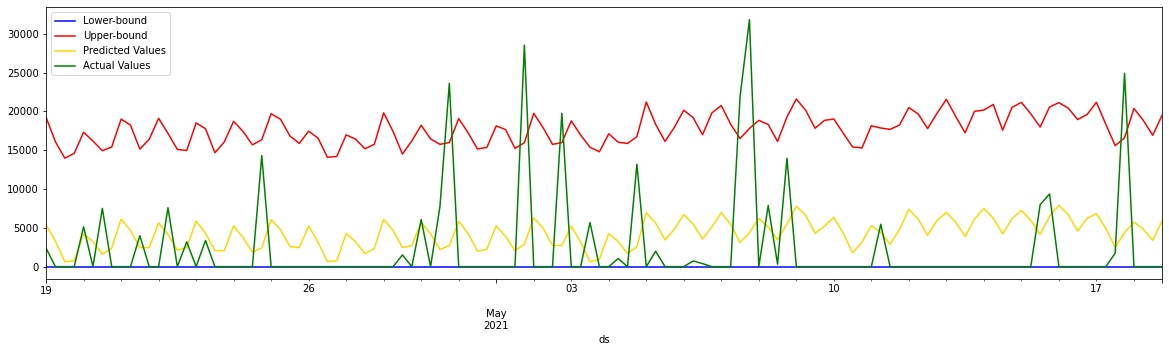

Event 7


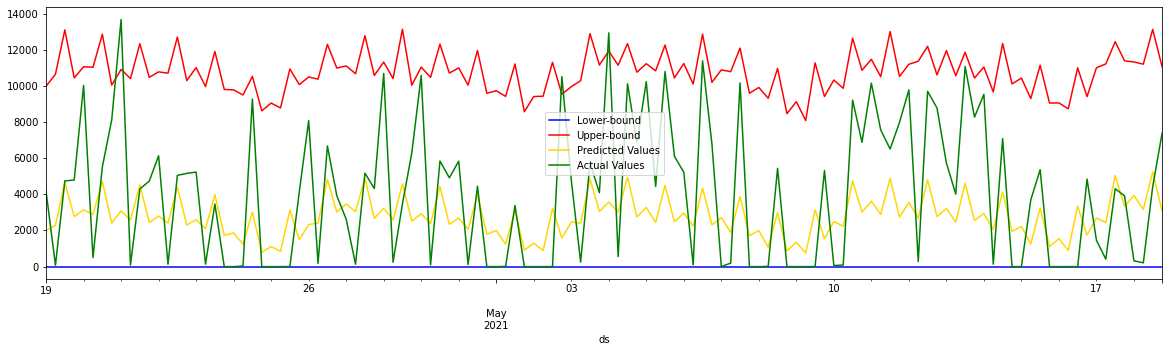

Event 14


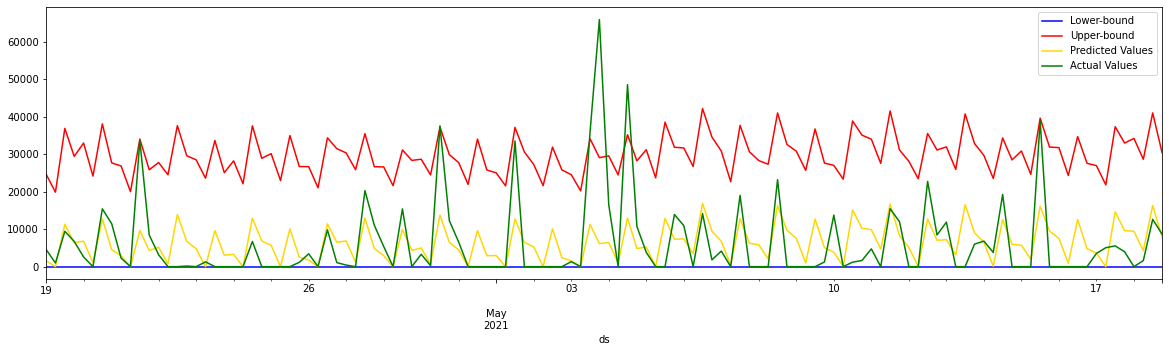

Event 335


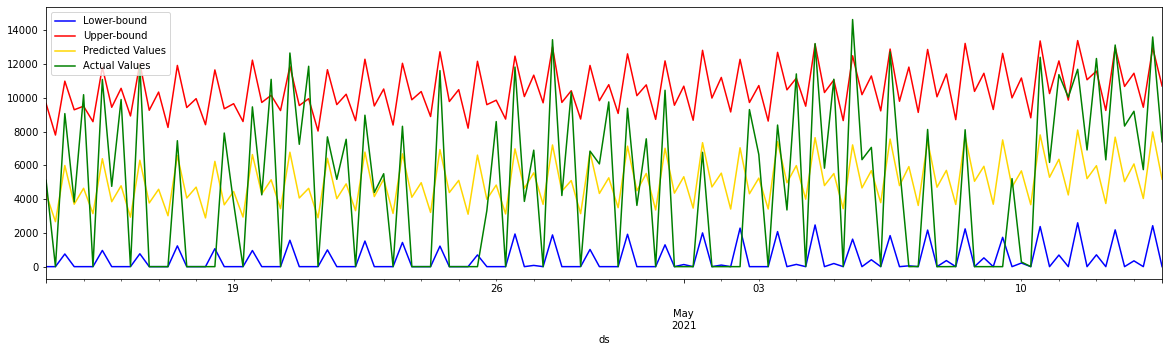

Event 33


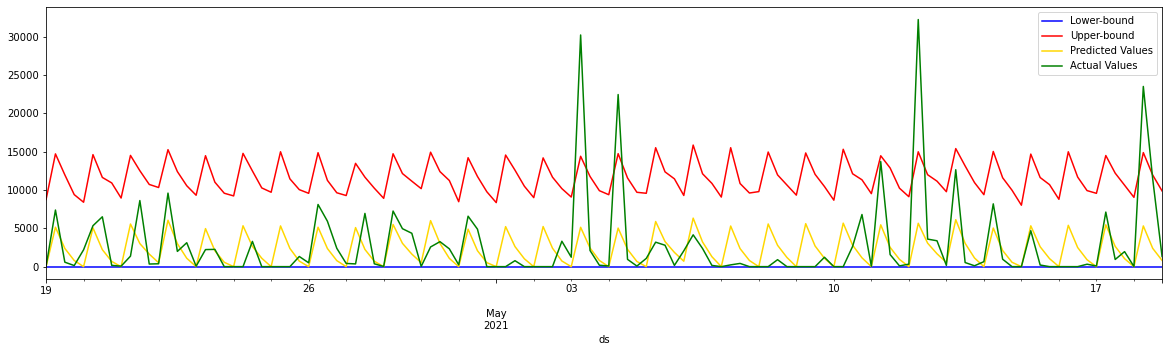

Event 337


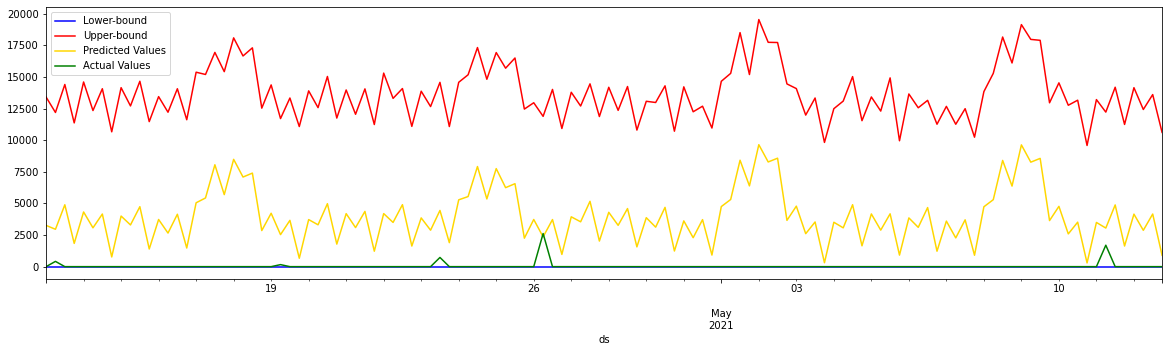

Event 336


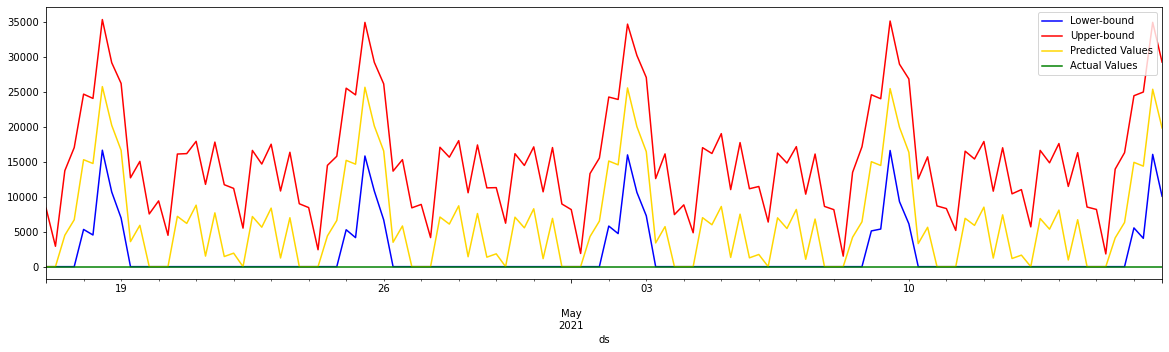

In [17]:
#most recent n days - graph plot with date, confidence interval, predicted and actual values

days_number=timedelta(days=30)

for final_trk in final_tracking_list:
    print(tracking_object,final_trk) 

    spec_trk=Final_CSV[Final_CSV[tracking_object] == final_trk]
    
    recent_30d = spec_trk[(spec_trk[forecast_datetime] > spec_trk[forecast_datetime].iloc[-1]-days_number)
                         & (spec_trk[forecast_datetime] <= spec_trk[forecast_datetime].iloc[-1])]
    ax = plt.gca()
    
    for y_val, labl, colr in zip(y_axis,label_list,color_list):
        recent_30d.plot(kind=graph_type,x=forecast_datetime,y=y_val, color=colr, label=labl, \
                        ax=ax, figsize=(20, 5))

    plt.fill_between(recent_30d.index, recent_30d.yhat_upper, recent_30d.yhat_lower, facecolor='orange',alpha=0.5)
    plt.show()

In [18]:
# all time metrics
y_pred=Final_CSV[predicted_value]
y_actual=Final_CSV[actual_value]
sample=len(Final_CSV.index)

mse = mean_squared_error(y_actual,y_pred)
rmse = math.sqrt(mse/sample)
rse = math.sqrt(mse/(sample-2))
r2=r2_score(y_actual,y_pred)
mae=mean_absolute_error(y_actual,y_pred)
median_ae=median_absolute_error(y_actual, y_pred)
mask=y_actual!=0
mape=(np.fabs((y_actual-y_pred)/y_actual))[mask].mean()
mpe=((y_actual-y_pred)/y_actual)[mask].mean()
med_ape=(np.fabs((y_actual-y_pred)/y_actual))[mask].median()
forecast_error = [y_actual[i]-y_pred[i] for i in range(len(y_pred))]
mean_forecast_error=sum(forecast_error)/len(y_pred)
smape=1/len(y_actual) * np.sum(2 * np.abs(y_pred-y_actual) / (np.abs(y_actual) + np.abs(y_pred))*100)
wape=np.sum(np.abs(y_actual-y_pred))/np.sum(np.abs(y_actual))
msle=mean_squared_log_error(y_actual, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('RSE: ', rse)
print('R^2: ', r2)
print('MAE: ', mae)
print('Median_AE: ', median_ae)
print('MPE: ', mpe)
print('MAPE:', mape)
print('MdAPE:', med_ape)
print('Mean Forecast Error: ', mean_forecast_error)
print('SMAPE: ', smape)
print('WAPE: ', wape)
print('MSLE: ', msle)
print('RMSLE: ', np.sqrt(msle))

MSE:  29278890.431692094
RMSE:  100.75803267381828
RSE:  100.7929877599258
R^2:  -0.08707298492659699
MAE:  3736.9205963938975
Median_AE:  2923.5
MPE:  -111.62339794984594
MAPE: 112.17857558888804
MdAPE: 0.6283772955460976
Mean Forecast Error:  -1306.5856449375867
SMAPE:  137.32310729125632
WAPE:  1.421405198802975
MSLE:  32.64115439248061
RMSLE:  5.713243771490991


In [19]:
#Interpretation
print("We are having an overestimated model, with a negative Mean Forecast Error.") #MFE
print("We should expect an average error of +- 101 packages, with RMSE are around 100.") #RMSE
print("The forecast error is 1.4%, meaning accuracy is 98.6%") #WAPE

### Unusable metrics interpretation ###
# print("The forecast's distance from the true value is 112% above of the true value, \ 
# which is around 3737 packages.") #MAPE/MAE
# print("Actual results are 112% less than what was forecasted. ") #MPE
# print("Half of the packages count are falling between median +- 2923 counts.") #Median_AE
# print("Half of the absolute percentage errors are less than 0.63% and half are over 0.63%.") #MdAPE

We are having an overestimated model, with a negative Mean Forecast Error.
We should expect an average error of +- 101 packages, with RMSE are around 100.
The forecast error is 1.4%, meaning accuracy is 98.6%


In [20]:
Formatted_CSV=Final_CSV

# Format output file
facility_name = 'IND3'
forecast_purpose = 'Event Count'

#Version - increment after each update
Formatted_CSV["Version"] = 1.0

#Forecast Date/Time
Formatted_CSV[forecast_datetime]=pd.to_datetime(Formatted_CSV[forecast_datetime])
col_list=['Forecast Date',
          'Forecast Time']
dt_notation=["%d %b %Y",
             "%I:%M %p"]
for col, notation in zip(col_list,dt_notation):
    Formatted_CSV[col]=[(d.date()).strftime(notation) for d in Formatted_CSV[forecast_datetime]]

#Lower/Upper boundary, Actuals, Forecast renames
old_name=['yhat_lower',
          'yhat_upper',
          actual_value,
          'yhat',
         ]
new_name=['Lower Boundary',
          'Upper Boundary',
          'Actual',
          'Forecast'
         ]
for old_col, new_col in zip(old_name,new_name):
    Formatted_CSV.rename(columns={old_col:new_col},inplace=True)

#Model Performance/Sensitivity
Formatted_CSV['Model Performance']=round(100-wape,2).astype(str)+"%"

#Anomaly - Predited and Actual
conditions = [
    Formatted_CSV['Actual'] < Formatted_CSV['Forecast'],
    Formatted_CSV['Actual'] > Formatted_CSV['Forecast'],
]
choices = ["Lower than expected", 
           "Higher than expected", 
          ]
Formatted_CSV['Anomaly'] = np.select(conditions,choices,default='')

#Anomaly - out of prediction interval
conditions = [
    Formatted_CSV['Actual'] < Formatted_CSV['Lower Boundary'],
    Formatted_CSV['Actual'] > Formatted_CSV['Upper Boundary']
]
choices = ["Out of Lower Bound", 
           "Out of Upper Bound", 
           ]
Formatted_CSV['Anomaly_Interval'] = np.select(conditions, choices,default='')

#Run date/time
col_list=['Run Date',
          'Run Time']
for col, notation in zip(col_list,dt_notation):
    Formatted_CSV[col]= (datetime.now().date()).strftime(notation)

#Sensitivity, comment - empty for now
Formatted_CSV["Sensitivity"],Formatted_CSV["Comment"] = "",""

#Monitor Name
Formatted_CSV["Monitor Name"] = facility_name +" "+ forecast_purpose
Formatted_CSV.head()

#Rearranging columns
cols = Formatted_CSV.columns.tolist()
cols = ['Monitor Name',
        'Version',
        tracking_object,
        'Run Date',
        'Run Time',
        'Forecast Date',
        'Forecast Time',
        'Model Performance',
        'Sensitivity',
        'Lower Boundary',
        'Upper Boundary',
        'Forecast',
        'Actual',
        'Anomaly',
        'Anomaly_Interval',
        'Comment'
       ]
Formatted_CSV=Formatted_CSV[cols]
Formatted_CSV.to_csv('IND3_Anomaly_Output_7Day_Formatted.csv')

In [21]:
Formatted_CSV.tail()

,Monitor Name,Version,Event,Run Date,Run Time,Forecast Date,Forecast Time,Model Performance,Sensitivity,Lower Boundary,Upper Boundary,Forecast,Actual,Anomaly,Anomaly_Interval,Comment
2879,IND3 Event Count,1.0,336,04 Aug 2021,12:00 AM,15 May 2021,12:00 AM,98.58%,,0.0,16327.0,6331.0,0.0,Lower than expected,,
2880,IND3 Event Count,1.0,336,04 Aug 2021,12:00 AM,16 May 2021,12:00 AM,98.58%,,5545.0,24476.0,14937.0,0.0,Lower than expected,Out of Lower Bound,
2881,IND3 Event Count,1.0,336,04 Aug 2021,12:00 AM,16 May 2021,12:00 AM,98.58%,,4056.0,25006.0,14392.0,0.0,Lower than expected,Out of Lower Bound,
2882,IND3 Event Count,1.0,336,04 Aug 2021,12:00 AM,16 May 2021,12:00 AM,98.58%,,16077.0,34989.0,25405.0,0.0,Lower than expected,Out of Lower Bound,
2883,IND3 Event Count,1.0,336,04 Aug 2021,12:00 AM,16 May 2021,12:00 AM,98.58%,,10081.0,29290.0,19862.0,0.0,Lower than expected,Out of Lower Bound,


In [22]:
#count number of out of bound records and its percentage
#total_oob is summed by upper_oob and lower_oob, which is the number of records falling out of upper/lower bound

total_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] != '')])
upper_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Upper Bound')])
lower_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Lower Bound')])

#these percentages are based on total number of records
print("Total out-of-bound forecast: ", total_oob, "-", round((total_oob/len(Formatted_CSV))*100,2),"%")
print("Total of upper OOB forecast: ", upper_oob, "-", round((upper_oob/len(Formatted_CSV))*100,2),"%")
print("Total of lower OOB forecast: ", lower_oob, "-", round((lower_oob/len(Formatted_CSV))*100,2),"%\n")

for final_trk in final_tracking_list:    
    print(tracking_object,final_trk)
    total_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] != '')&\
                                  (Formatted_CSV['Event']==final_trk)])
    upper_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Upper Bound')&\
                                  (Formatted_CSV['Event']==final_trk)])
    lower_oob = len(Formatted_CSV[(Formatted_CSV['Anomaly_Interval'] == 'Out of Lower Bound')&\
                                  (Formatted_CSV['Event']==final_trk)])
    total_tracking= len(Formatted_CSV[(Formatted_CSV['Event']==final_trk)])
    
    #these percentages based on the total number of records for a specific event
    print("Total OOB: ", total_oob, "-",round((total_oob/total_tracking)*100,2),"%")
    print("Upper OOB: ", upper_oob, "-",round((upper_oob/total_tracking)*100,2),"%")
    print("Lower OOB: ", lower_oob, "-",round((lower_oob/total_tracking)*100,2),"%\n")

Total out-of-bound forecast:  149 - 5.17 %
Total of upper OOB forecast:  92 - 3.19 %
Total of lower OOB forecast:  57 - 1.98 %

Event 334
Total OOB:  6 - 4.29 %
Upper OOB:  6 - 4.29 %
Lower OOB:  0 - 0.0 %

Event 333
Total OOB:  1 - 0.71 %
Upper OOB:  1 - 0.71 %
Lower OOB:  0 - 0.0 %

Event 35
Total OOB:  9 - 2.14 %
Upper OOB:  9 - 2.14 %
Lower OOB:  0 - 0.0 %

Event 7
Total OOB:  20 - 4.76 %
Upper OOB:  20 - 4.76 %
Lower OOB:  0 - 0.0 %

Event 14
Total OOB:  8 - 1.9 %
Upper OOB:  8 - 1.9 %
Lower OOB:  0 - 0.0 %

Event 335
Total OOB:  60 - 15.31 %
Upper OOB:  36 - 9.18 %
Lower OOB:  24 - 6.12 %

Event 33
Total OOB:  9 - 2.14 %
Upper OOB:  9 - 2.14 %
Lower OOB:  0 - 0.0 %

Event 337
Total OOB:  11 - 2.81 %
Upper OOB:  3 - 0.77 %
Lower OOB:  8 - 2.04 %

Event 336
Total OOB:  25 - 17.86 %
Upper OOB:  0 - 0.0 %
Lower OOB:  25 - 17.86 %

